# 04-classification hw

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [64]:
df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data preparation

In [65]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [66]:
for col in df.columns:
    print(col)
    print(df[col].dtype)  # pandas dtype
    check_type = df[col].dtype
    missing = df[col].isnull().sum()
    if check_type == object:
        #categorical.append(col)
        if missing > 0: 
            df[col] = df[col].fillna('NA')
            print('Column with missing values and string dtype')
    else:
        #numerical.append(col)
        if missing > 0:
            df[col] = df[col].fillna(0)
            print('Column with missing values and numeric dtype')
    print('---')

lead_source
object
Column with missing values and string dtype
---
industry
object
Column with missing values and string dtype
---
number_of_courses_viewed
int64
---
annual_income
float64
Column with missing values and numeric dtype
---
employment_status
object
Column with missing values and string dtype
---
location
object
Column with missing values and string dtype
---
interaction_count
int64
---
lead_score
float64
---
converted
int64
---


In [67]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### Split the data

In [85]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#### Q1 ROC AUC

In [69]:
from sklearn.metrics import roc_auc_score

In [70]:
df_train.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [74]:
y = df_train.converted.values

for col in df_train.columns:
    check_type = df_train[col].dtype
    if check_type != 'object':
        score = roc_auc_score(y, df_train[col].values)
        if score < 0.5:
            score = roc_auc_score(y, -df_train[col].values)
            print(f"{col}: {score}")
        else:
            print(f"{col}: {score}")

number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5519578313253012
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176
converted: 1.0


#### Q2: Training

In [83]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [86]:
y_train = df_train.converted.values
y_val = df_val.converted.values
del df_train['converted']
del df_val['converted']

In [87]:
dv, model = train(df_train, y_train, C=1.0)
y_pred = predict(df_val, dv, model)

In [88]:
auc = roc_auc_score(y_val, y_pred)
auc

0.8171316268814112

#### Q3: Precision and recall

In [91]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [92]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,171,122,0,0,0.583618,1.000000
10,0.1,171,122,0,0,0.583618,1.000000
20,0.2,171,122,0,0,0.583618,1.000000
30,0.3,171,119,0,3,0.589655,1.000000
40,0.4,171,105,0,17,0.619565,1.000000
50,0.5,164,81,7,41,0.669388,0.959064
60,0.6,150,53,21,69,0.738916,0.877193
70,0.7,106,25,65,97,0.809160,0.619883
80,0.8,64,6,107,116,0.914286,0.374269
90,0.9,24,1,147,121,0.960000,0.140351


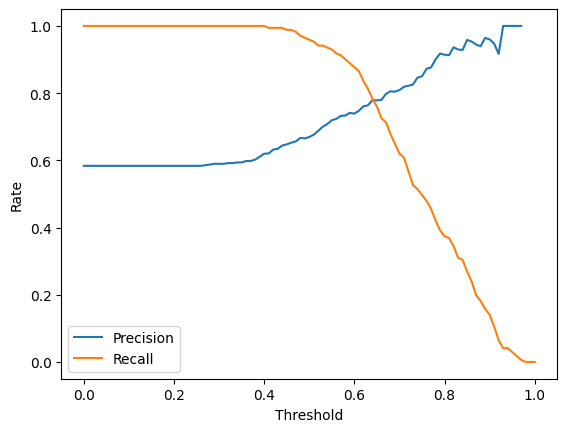

In [93]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()

In [94]:
df_scores['F1'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,F1
0,0.0,171,122,0,0,0.583618,1.000000,0.737069
10,0.1,171,122,0,0,0.583618,1.000000,0.737069
20,0.2,171,122,0,0,0.583618,1.000000,0.737069
30,0.3,171,119,0,3,0.589655,1.000000,0.741866
40,0.4,171,105,0,17,0.619565,1.000000,0.765101
50,0.5,164,81,7,41,0.669388,0.959064,0.788462
60,0.6,150,53,21,69,0.738916,0.877193,0.802139
70,0.7,106,25,65,97,0.809160,0.619883,0.701987
80,0.8,64,6,107,116,0.914286,0.374269,0.531120
90,0.9,24,1,147,121,0.960000,0.140351,0.244898


In [95]:
df_scores[df_scores.F1 == df_scores.F1.max()]

,threshold,tp,fp,fn,tn,precision,recall,F1
57,0.57,156,57,15,65,0.732394,0.912281,0.8125


#### Q5

In [97]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_index, val_index in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_index]
        df_val = df_full_train.iloc[val_index]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        del df_train['converted']
        del df_val['converted']
        
        dv, model = train(df_train, y_train, C=1.0)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

In [98]:
print(np.mean(scores), np.std(scores))

0.8221089148573075 0.03580711942905165


#### Q6:

In [100]:
for C in [0.000001, 0.001, 1]:
    scores = []
    for train_index, val_index in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_index]
        df_val = df_full_train.iloc[val_index]

        y_train = df_train.converted.values
        y_val = df_val.converted.values
        del df_train['converted']
        del df_val['converted']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%.6f %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.000001 0.822 +- 0.036
C=0.001000 0.822 +- 0.036
C=1.000000 0.822 +- 0.036
